In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller1 import player_controller
from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
def run_algorithm_a(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1):
    """
    Runs Genetic Algorithm A with the provided environment and parameters.

    Parameters:
    - env: Evoman Environment instance.
    - npopulation: Population size.
    - gens: Number of generations.
    - mutation_rate: Mutation rate.
    - dom_u: Upper bound for gene values.
    - dom_l: Lower bound for gene values.
    - elitism_count: Number of elites to preserve.

    Returns:
    - history_mean: List of mean fitness per generation.
    - history_max: List of max fitness per generation.
    - best_solution: Best solution found.
    """
    n_hidden_neurons_1 = 10
    n_hidden_neurons_2 = 5

    n_vars = (
        (env.get_num_sensors() + 1) * n_hidden_neurons_1 +  # Weights and biases from input -> hidden layer 1
        (n_hidden_neurons_1 + 1) * n_hidden_neurons_2 +  # Weights and biases from hidden layer 1 -> hidden layer 2
        (n_hidden_neurons_2 + 1) * 5  # Weights and biases from hidden layer 2 -> output layer (5 actions)
    )

    # Run the simulation and return the fitness
    def simulate(x):
        env.player_controller.set(x, env.get_num_sensors())
        f, _, _, _ = env.play(pcont=x)
        return f

    # Evaluate the current population
    def evaluate(population):
        return np.array([simulate(individual) for individual in population])

    # Tournament Selection
    def tournament_selection(population, fitness, k=5):
        selected = []
        for _ in range(len(population)):
            contenders = np.random.choice(len(population), k, replace=False)
            winner = contenders[np.argmax(fitness[contenders])]
            selected.append(population[winner])
        return np.array(selected)

    # Uniform Crossover
    def crossover(parent1, parent2):
        mask = np.random.rand(n_vars) < 0.5
        child1 = np.where(mask, parent1, parent2)
        child2 = np.where(mask, parent2, parent1)
        return child1, child2

    # Gaussian Mutation
    def mutate(child):
        for i in range(n_vars):
            if np.random.rand() < mutation_rate:
                child[i] += np.random.normal(0, 0.1)
                child[i] = np.clip(child[i], dom_l, dom_u)
        return child

    # Initialize population
    population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
    fitness = evaluate(population)

    # Record fitness over generations
    history_mean = []
    history_max = []

    # Genetic Algorithm Loop
    for generation in range(1, gens + 1):
        # Selection
        selected = tournament_selection(population, fitness)

        # Crossover
        offspring = []
        for i in range(0, npopulation, 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([child1, child2])
        offspring = np.array(offspring)[:npopulation]

        # Mutation
        offspring = np.array([mutate(child) for child in offspring])

        # Evaluation
        offspring_fitness = evaluate(offspring)

        # Replacement: Elitism (keep the best individual)
        best_idx = np.argmax(fitness)
        worst_idx = np.argmin(offspring_fitness)
        if fitness[best_idx] > offspring_fitness[worst_idx]:
            offspring[worst_idx] = population[best_idx]
            offspring_fitness[worst_idx] = fitness[best_idx]

        population, fitness = offspring, offspring_fitness

        # Record statistics
        history_mean.append(np.mean(fitness))
        history_max.append(np.max(fitness))

        # Logging
        print(f'Generation {generation}: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

    # Get best solution
    best_idx = np.argmax(fitness)
    best_solution = population[best_idx]

    np.savetxt('best_solution_a.txt', best_solution)

    return history_mean, history_max, best_solution


In [3]:
def run_algorithm_b(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1, elitism_count=2, share_alpha=0.1, share_sigma=0.2):
    """
    Runs Genetic Algorithm B (GA with Fitness Sharing for diversity maintenance).

    Parameters:
    - env: Evoman Environment instance.
    - npopulation: Population size.
    - gens: Number of generations.
    - mutation_rate: Mutation rate.
    - dom_u: Upper bound for gene values.
    - dom_l: Lower bound for gene values.
    - elitism_count: Number of elites to preserve.
    - share_alpha: Sharing coefficient.
    - share_sigma: Sharing radius.

    Returns:
    - history_mean: List of mean fitness per generation.
    - history_max: List of max fitness per generation.
    - best_solution: Best solution found.
    """

    n_hidden_neurons_1 = 10
    n_hidden_neurons_2 = 5

    n_vars = (
        (env.get_num_sensors() + 1) * n_hidden_neurons_1 +  # Weights and biases from input -> hidden layer 1
        (n_hidden_neurons_1 + 1) * n_hidden_neurons_2 +  # Weights and biases from hidden layer 1 -> hidden layer 2
        (n_hidden_neurons_2 + 1) * 5  # Weights and biases from hidden layer 2 -> output layer (5 actions)
    )

    # Run the simulation and return the fitness
    def simulate(x):
        # Set the player's controller with the weights 'x'
        env.player_controller.set(x, env.get_num_sensors())
        f, _, _, _ = env.play(pcont=x)
        return f

    # Evaluate the current population
    def evaluate(population):
        return np.array([simulate(individual) for individual in population])

    # Tournament Selection
    def tournament_selection(population, fitness, k=5):
        selected = []
        for _ in range(len(population)):
            contenders = np.random.choice(len(population), k, replace=False)
            winner = contenders[np.argmax(fitness[contenders])]
            selected.append(population[winner])
        return np.array(selected)

    # Two-Point Crossover
    def two_point_crossover(parent1, parent2):
        point1 = np.random.randint(0, n_vars)
        point2 = np.random.randint(point1, n_vars)
        child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
        child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])
        return child1, child2

    # Gaussian Mutation
    def mutate(child):
        for i in range(n_vars):
            if np.random.rand() < mutation_rate:
                child[i] += np.random.normal(0, 0.1)
                child[i] = np.clip(child[i], dom_l, dom_u)
        return child

    # Fitness Sharing
    def fitness_sharing(population, fitness, alpha, sigma):
        """
        Adjusts fitness based on similarity using fitness sharing.

        Parameters:
        - population: Current population.
        - fitness: Original fitness values.
        - alpha: Sharing coefficient.
        - sigma: Sharing radius.

        Returns:
        - shared_fitness: Adjusted fitness values.
        """
        shared_fitness = np.copy(fitness)
        npop = population.shape[0]
        for i in range(npop):
            for j in range(npop):
                if i != j:
                    distance = np.linalg.norm(population[i] - population[j])
                    if distance < sigma:
                        shared_fitness[i] -= alpha * (1 - distance / sigma)
        # Ensure that fitness doesn't become negative
        shared_fitness = np.maximum(shared_fitness, 0)
        return shared_fitness

    # Initialize population
    population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
    fitness = evaluate(population)

    # Apply Fitness Sharing
    fitness = fitness_sharing(population, fitness, share_alpha, share_sigma)

    # Record fitness over generations
    history_mean = []
    history_max = []

    # Genetic Algorithm Loop
    for generation in range(1, gens + 1):
        # Selection
        selected = tournament_selection(population, fitness)

        # Crossover
        offspring = []
        for i in range(0, npopulation, 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = two_point_crossover(parent1, parent2)
            offspring.extend([child1, child2])
        offspring = np.array(offspring)[:npopulation]

        # Mutation
        offspring = np.array([mutate(child) for child in offspring])

        # Evaluation
        offspring_fitness = evaluate(offspring)

        # Apply Fitness Sharing
        offspring_fitness = fitness_sharing(offspring, offspring_fitness, share_alpha, share_sigma)

        # Replacement: Elitism (keep the best individual)
        best_idx = np.argmax(fitness)
        worst_idx = np.argmin(offspring_fitness)
        if fitness[best_idx] > offspring_fitness[worst_idx]:
            offspring[worst_idx] = population[best_idx]
            offspring_fitness[worst_idx] = fitness[best_idx]

        population, fitness = offspring, offspring_fitness

        # Record statistics
        history_mean.append(np.mean(fitness))
        history_max.append(np.max(fitness))

        # Logging
        print(f'Generation {generation}: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

    # Get best solution
    best_idx = np.argmax(fitness)
    best_solution = population[best_idx]

    np.savetxt(('best_solution_b.txt'), best_solution)

    return history_mean, history_max, best_solution


In [4]:
# Experiment Parameters
enemy = 6 # singular enemy to test
num_runs = 10 # Change to 10 for full experiment
npopulation = 200
gens = 30 # Change to 30 for full experiment
mutation_rate = 0.05
dom_u, dom_l = 1, -1
elitism_count_a = 1
elitism_count_b = 2
# Define the list of enemies to train against
enemies = [1, 2, 3]  

# The number of hidden neurons for the player controller
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 5

# Initialize data storage
results = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Generation': [],
    'Mean Fitness': [],
    'Max Fitness': [],
    'Best Solution': []
}

best_solutions = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Best Solution': []
}

### Run this for Algorithm A results

In [ ]:
for enemy in enemies:
    print(f"Training against enemy {enemy}")
        
    for run in range(1, num_runs + 1):
        print(f"Run {run}/{num_runs}")
        
        # Define experiment names for Algorithm A and B
        experiment_name_a = f'optimization_test_a_run_{run}'
        experiment_name_b = f'optimization_test_b_run_{run}'
        
        # Create directories for Algorithm A and B
        os.makedirs(experiment_name_a, exist_ok=True)
        os.makedirs(experiment_name_b, exist_ok=True)
        
        # Initialize Environment for Algorithm A
        env_a = Environment(
            experiment_name=experiment_name_a,
            enemies=[enemy],
            playermode="ai",
            player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
            enemymode="ai",
            level=2,
            speed="fastest",
            visuals=False
        )
        
        # Run Algorithm A
        mean_a, max_a, best_a = run_algorithm_a(
            env=env_a,
            npopulation=npopulation,
            gens=gens,
            mutation_rate=mutation_rate,
            dom_u=dom_u,
            dom_l=dom_l
        )
        
        # Record data for Algorithm A
        for gen in range(1, gens + 1):
            results['Algorithm'].append('A')
            results['Enemy'].append(enemy)
            results['Run'].append(run)
            results['Generation'].append(gen)
            results['Mean Fitness'].append(mean_a[gen - 1])
            results['Max Fitness'].append(max_a[gen - 1])
            results['Best Solution'].append(best_a)
        
        best_solutions['Algorithm'].append('A')
        best_solutions['Enemy'].append(enemy)
        best_solutions['Run'].append(run)
        best_solutions['Best Solution'].append(best_a)

        # Initialize Environment for Algorithm B
        env_b = Environment(
            experiment_name=experiment_name_b,
            enemies=[enemy],
            playermode="ai",
            player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
            enemymode="ai",
            level=2,
            speed="fastest",
            visuals=False
        )
        
        # Run Algorithm B
        mean_b, max_b, best_b = run_algorithm_b(
            env=env_b,
            npopulation=npopulation,
            gens=gens,
            mutation_rate=mutation_rate,
            dom_u=dom_u,
            dom_l=dom_l,
            elitism_count=elitism_count_b
        )
        
        # Record data for Algorithm B
        for gen in range(1, gens + 1):
            results['Algorithm'].append('B')
            results['Enemy'].append(enemy)
            results['Run'].append(run)
            results['Generation'].append(gen)
            results['Mean Fitness'].append(mean_b[gen - 1])
            results['Max Fitness'].append(max_b[gen - 1])
            results['Best Solution'].append(best_b)
        
        best_solutions['Algorithm'].append('B')
        best_solutions['Enemy'].append(enemy)
        best_solutions['Run'].append(run)
        best_solutions['Best Solution'].append(best_b)

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('results_a.csv', index=False)

best_solutions_df = pd.DataFrame(best_solutions)
best_solutions_df.to_csv('best_solutions_a.csv', index=False)

### Run this for Algorithm B 

In [6]:
for enemy in enemies:
	print(f"Training against enemy {enemy}")
		
	for run in range(1, num_runs + 1):
		print(f"Run {run}/{num_runs}")
		
		experiment_name_b = f'optimization_test_b_run_{run}'
		os.makedirs(experiment_name_b, exist_ok=True)
		
		# Initialize Environment for Algorithm B
		env_b = Environment(
			experiment_name=experiment_name_b,
			enemies=[enemy],
			playermode="ai",
			player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
			enemymode="ai",
			level=2,
			speed="fastest",
			visuals=False
		)
		
		# Run Algorithm B
		mean_b, max_b, best_b = run_algorithm_b(
			env=env_b,
			npopulation=npopulation,
			gens=gens,
			mutation_rate=mutation_rate,
			dom_u=dom_u,
			dom_l=dom_l,
			elitism_count=elitism_count_b
		)
		
		# Record data for Algorithm B
		for gen in range(1, gens + 1):
			results['Algorithm'].append('B')
			results['Enemy'].append(enemy)
			results['Run'].append(run)
			results['Generation'].append(gen)
			results['Mean Fitness'].append(mean_b[gen - 1])
			results['Max Fitness'].append(max_b[gen - 1])
			results['Best Solution'].append(best_b)
		
		best_solutions['Algorithm'].append('B')
		best_solutions['Enemy'].append(enemy)
		best_solutions['Run'].append(run)
		best_solutions['Best Solution'].append(best_b)

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('results_b.csv', index=False)

best_solutions_df = pd.DataFrame(best_solutions)
best_solutions_df.to_csv('best_solutions_b.csv', index=False)

Training against enemy 1
Run 1/10

MESSAGE: Pygame initialized for simulation.
Generation 1: Best Fitness = 94.3063, Mean Fitness = 10.7957
Generation 2: Best Fitness = 94.3198, Mean Fitness = 28.6102
Generation 3: Best Fitness = 94.3232, Mean Fitness = 55.9893
Generation 4: Best Fitness = 94.3232, Mean Fitness = 65.2768
Generation 5: Best Fitness = 94.3232, Mean Fitness = 66.1391
Generation 6: Best Fitness = 94.3232, Mean Fitness = 75.5602
Generation 7: Best Fitness = 94.3232, Mean Fitness = 70.8233
Generation 8: Best Fitness = 94.3232, Mean Fitness = 71.6716
Generation 9: Best Fitness = 94.3232, Mean Fitness = 73.8551
Generation 10: Best Fitness = 94.3232, Mean Fitness = 79.3970
Generation 11: Best Fitness = 94.3232, Mean Fitness = 80.3704
Generation 12: Best Fitness = 94.3232, Mean Fitness = 77.7461
Generation 13: Best Fitness = 94.3232, Mean Fitness = 82.8294
Generation 14: Best Fitness = 94.3232, Mean Fitness = 79.9246
Generation 15: Best Fitness = 94.3232, Mean Fitness = 80.6326


In [7]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = results_df.groupby(['Algorithm', 'Enemy', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std')
).reset_index()

In [8]:
# Display the first few rows of the grouped data
grouped.head()

,Algorithm,Enemy,Generation,mean_fitness_mean,mean_fitness_std,max_fitness_mean,max_fitness_std
0,B,1,1,15.299971,5.191247,94.134398,0.568531
1,B,1,2,36.821586,11.836119,94.318473,0.004600
2,B,1,3,60.122940,8.203918,94.322975,0.012627
3,B,1,4,67.369410,5.902745,94.323997,0.012135
4,B,1,5,69.811033,5.361917,94.324680,0.011850


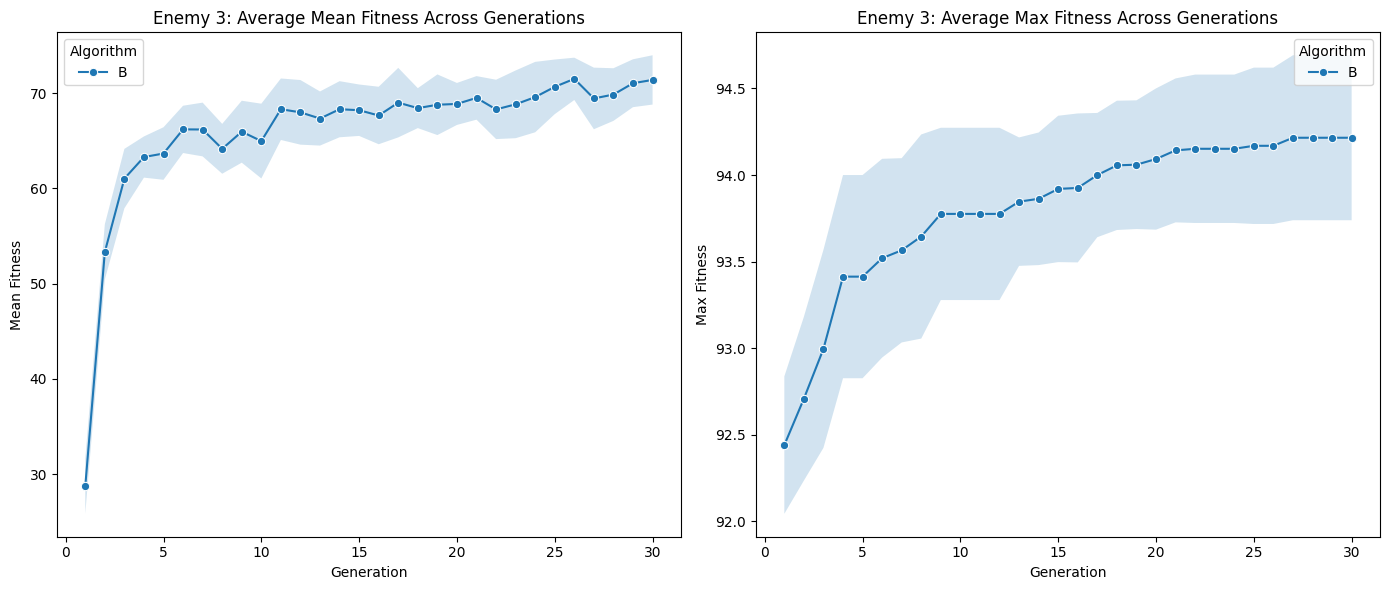

In [9]:
plt.figure(figsize=(14, 6))

# Subset data for the current enemy
data_enemy = grouped[grouped['Enemy'] == enemy]

# Plot Mean Fitness
plt.subplot(1, 2, 1)
sns.lineplot(data=data_enemy, x='Generation', y='mean_fitness_mean', hue='Algorithm', marker='o')
plt.fill_between(
	data_enemy['Generation'],
	data_enemy['mean_fitness_mean'] - data_enemy['mean_fitness_std'],
	data_enemy['mean_fitness_mean'] + data_enemy['mean_fitness_std'],
	alpha=0.2
)
plt.title(f'Enemy {enemy}: Average Mean Fitness Across Generations')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.legend(title='Algorithm')

# Plot Max Fitness
plt.subplot(1, 2, 2)
sns.lineplot(data=data_enemy, x='Generation', y='max_fitness_mean', hue='Algorithm', marker='o')
plt.fill_between(
	data_enemy['Generation'],
	data_enemy['max_fitness_mean'] - data_enemy['max_fitness_std'],
	data_enemy['max_fitness_mean'] + data_enemy['max_fitness_std'],
	alpha=0.2
)
plt.title(f'Enemy {enemy}: Average Max Fitness Across Generations')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.legend(title='Algorithm')

plt.tight_layout()
plt.show()


# TODO: Run the best solution on 2 other enemies

In [ ]:
enemies = [1, 6, 8]

experiment_name = 'test_other_enemies'
os.makedirs(experiment_name, exist_ok=True)

# Load best solutions
best_solutions_a = np.loadtxt('best_solution_b.txt')

n_hidden1 = 10
n_hidden2 = 5

for enemy in enemies:
	env = Environment(
		experiment_name=experiment_name,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden1, n_hidden2),
		enemymode="ai",
		level=2,
		speed="fastest",
		visuals=True
	)

	f, _, _, _ = env.play(pcont=best_solutions_a)

	print(f'Enemy {enemy}: Fitness = {f:.4f}')

# TODO: Fix Gain


In [12]:
def calculate_gain(solution, enemy, experiment_name, n_hidden_neurons_1, n_hidden_neurons_2, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    
    env = Environment(
        experiment_name=experiment_name,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
		enemymode="ai",
		level=2,
		speed="fastest",
		visuals=False
    )
    
    gains = []
    for _ in range(num_tests):
        env.player_controller.set(solution, env.get_num_sensors())
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    return gains

In [16]:
solutions_df = pd.read_csv('results_b.csv')

In [17]:
# Initialize data storage for gains
gains_data = {
	'Algorithm': [],
	'Enemy': [],
	'Run': [],
	'Gain': []
}

# Collect Gains for Best Solutions
for index, row in solutions_df.iterrows():
	algo = row['Algorithm']
	enemy = row['Enemy']
	run = row['Run']
	solution = row['Best Solution']
	
	n_hidden_neurons_1 = 10
	n_hidden_neurons_2 = 5

	# n_vars = (
	# 	(env.get_num_sensors() + 1) * n_hidden_neurons_1 +  # Weights and biases from input -> hidden layer 1
	# 	(n_hidden_neurons_1 + 1) * n_hidden_neurons_2 +  # Weights and biases from hidden layer 1 -> hidden layer 2
	# 	(n_hidden_neurons_2 + 1) * 5  # Weights and biases from hidden layer 2 -> output layer (5 actions)
	# )
	
	# Define a unique experiment name for gain calculation
	experiment_name_gain = f'gains_{algo}_enemy_{enemy}_run_{run}'
	
	# Calculate gains
	gains = calculate_gain(solution, enemy, experiment_name_gain, n_hidden_neurons_1, n_hidden_neurons_2, num_tests=5)
	
	for gain in gains:
		gains_data['Algorithm'].append(algo)
		gains_data['Enemy'].append(enemy)
		gains_data['Run'].append(run)
		gains_data['Gain'].append(gain)

# Convert to DataFrame
df_gains = pd.DataFrame(gains_data)

# Display the first few rows of the gains data
df_gains.head()


MESSAGE: Pygame initialized for simulation.


AttributeError: 'str' object has no attribute 'reshape'

: 

In [ ]:
for enemy in enemies:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_gains[(df_gains['Enemy'] == enemy)], x='Algorithm', y='Gain')
    plt.title(f'Enemy {enemy}: Individual Gain Comparison Between Algorithms')
    plt.xlabel('Algorithm')
    plt.ylabel('Gain (Player Energy - Enemy Energy)')
    plt.show()